# Listing 1
## Pseudocode for neighborhood Q-learning, part 1

# Listing 2
## Pseudocode for neighborhood Q-learning, part 2

# Listing 3
## 1D Ising model: Create the grid and produce rewards

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

def init_grid(size=(10, )):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte() # converts the floating-point numbers into a byte object to make it binary
    return grid

def get_reward(s, a): # this function takes neighbors in s and compares them to agent a; if they match, the reward is higher
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r

In [7]:
size = (20, )
grid = init_grid(size=size)
grid

tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
       dtype=torch.uint8)

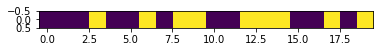

In [8]:
plt.imshow(np.expand_dims(grid, 0))

# Listing 4
## The 1D Ising model: Generate neural network parameters

In [9]:
def gen_params(N, size): # this function generates a list of parameter vectors for a neural network
    ret = []
    for i in range(N):
        vec = torch.randn(size) / 10.
        vec.requires_grad = True
        ret.append(vec)
    return ret

# Listing 5
## The 1D Ising model: Defining the Q function

In [10]:
def qfunc(s, theta, layers=[(4, 20), (20, 2)], afn=torch.tanh):
    l1n = layers[0]
    l1s = np.prod(l1n) # takes the first tuple in layers and multiplies those numbers to get the subset of the theta vector to use as the first layer
    theta_1 = theta[0 : l1s].reshape(l1n) # reshapes the theta vector subset into a matrix for use as the first layer of the neural network
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s : l2s + l1s].reshape(l2n)
    bias = torch.ones((1, theta_1.shape[1]))
    l1 = s @ theta_1 + bias # this is the first layer computation. The s input is a joint-action vector of dimensions (4, 1)
    l1 = torch.nn.functional.elu(l1)
    l2 = afn(l1 @ theta_2)
    return l2.flatten() # we can also input an activation function to use for the last layer; the default is tanh since our reward ranges [-1, 1]

# Listing 6
## The 1D Ising model: Get the state of the environment

In [11]:
def get_substate(b): # takes a single binary number and turns it into a one-hot encoded action vector like [0, 1]
    s = torch.zeros(2)
    if b > 0: # if the input is 0 (down), the action vector is [1, 0]; otherwise it is [0, 1]
        s[1] = 1
    else:
        s[0] = 1
    return s

def joint_state(s): # s is a vector with 2 elements where s[0] = left neighbor, s[1] = right neighbor
    s1_ = get_substate(s[0]) # gets the action vectors for each element in s
    s2_ = get_substate(s[1])
    ret = (s1_.reshape(2, 1) @ s2_.reshape(1, 2)).flatten() # creates the joint-action space using the outer-product, then flattens into a vector
    return ret

# Listing 7
## The 1D Ising model: Initialize the grid

tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
       dtype=torch.uint8)


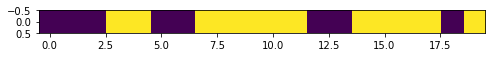

In [12]:
plt.figure(figsize=(8, 5))
size = (20, ) # sets the total size of the grid to be a 20-length vector
hid_layer = 20 # sets the size of the hidden layer. Our Q function is just a 2-layer neural network, so there's only one hidden layer
params = gen_params(size[0], 4 * hid_layer + hid_layer * 2) # generates a list of parameter vectors that will parameterize the Q function
grid = init_grid(size=size)
grid_ = grid.clone() # makes a clone of the grid (for main training loop)
print(grid)
plt.imshow(np.expand_dims(grid, 0))

# Listing 8
## The 1D Ising model: The training loop

In [13]:
epochs = 200
lr = 0.001 # learning rate
losses = [[] for i in range(size[0])] # since we're dealing with multiple agents, each controlled by a separate Q function, we have to keep track of multiple losses
for i in range(epochs):
    for j in range(size[0]): # iterates through each agent
        l = j - 1 if j - 1 >= 0 else size[0] - 1 # gets the left neighbor; if at the beginning, loops to the end
        r = j + 1 if j + 1 < size[0] else 0 # gets the right neighbor; if at the end, loops to the beginning
        state_ = grid[[l, r]] # state_ is the two binary digits representing the spins of the left and right neighbors
        state = joint_state(state_) # state is a vector of two binary digits representing actions of two agents; turn this into a one-hot joint-action vector
        qvals = qfunc(state.float().detach(), params[j], layers=[(4, hid_layer), (hid_layer, 2)])
        qmax = torch.argmax(qvals, dim=0).detach().item() # the policy is to take the action associated with the highest Q value
        action = int(qmax)
        grid_[j] = action # we take the action in our temporary copy of the grid, grid_, and only once all agents have taken actions do we copy them into the main grid
        reward = get_reward(state_.detach(), action)
        with torch.no_grad(): # the target value is the Q value vector with the Q value associated with the action taken replaced with the reward observed
            target = qvals.clone()
            target[action] = reward
        loss = torch.sum(torch.pow(qvals - target, 2))
        losses[j].append(loss.detach().numpy())
        loss.backward()
        with torch.no_grad(): # manual gradient descent
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True
    with torch.no_grad(): # copies the contents of the temporary grid_ into the main grid vector
        grid.data = grid_.data

tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       dtype=torch.uint8) tensor(6)


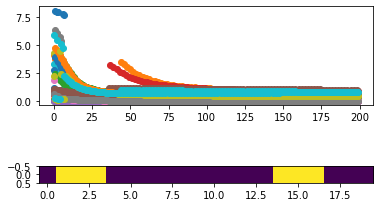

In [14]:
fig, ax = plt.subplots(2, 1)
for i in range(size[0]):
    ax[0].scatter(np.arange(len(losses[i])), losses[i])
print(grid, grid.sum())
ax[1].imshow(np.expand_dims(grid, 0))

# Listing 9
## Mean field Q-learning: The policy function

In [16]:
from collections import deque # we will use the deque data structure as an experience replay storage list, since it can be set to have a maximum size
from random import shuffle # we will use the shuffle function to shuffle the experience replay buffer

def softmax_policy(qvals, temp=0.9): # this policy function takes in a Q value vector and return an action, either 0 (down) or 1 (up)
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp)) # this is the softmax function definition
    action = torch.multinomial(soft, 1) # the softmax function converts the Q values into a probability distribution over the actions. We use the multinomial function to randomly select an action weighted by the probabilities
    return action

# Listing 10
## Mean field Q-learning: Coordinate and reward functions

In [17]:
def get_coords(grid, j): # takes a single index value from the flattened grid and converts it back to [x, y] ccoordinates
    x = int(np.floor(j / grid.shape[0])) # finds the x coordinate
    y = int(j - x * grid.shape[0]) # finds the y coordinate
    return x, y

def get_reward_2d(action, action_mean): # this is the reward function for the 2D grid
    r = (action * (action_mean - action / 2)).sum() / action.sum() # the reward is based on how different the action is from the mean field action
    return torch.tanh(5 * r) # scales the reward to be between [-1, +1] using the tanh function

In [20]:
print(get_reward_2d(torch.Tensor([1, 0]), torch.Tensor([0.25, 0.75])))
print(get_reward_2d(torch.Tensor([0, 1]), torch.Tensor([0.25, 0.75])))

tensor(-0.8483)
tensor(0.8483)


# Listing 11
# Mean field Q-learning: Calculate the mean action vector

In [19]:
def mean_action(grid, j):
    x, y = get_coords(grid, j) # converts vectorized index j into grid coordinates [x, y] where [0, 0] is top left
    action_mean = torch.zeros(2) # this will be the action mean vector that we will add to
    for i in [-1, 0, 1]: # two for loops allow us to find each of the 8 nearest neighbors of agent j
        for k in [-1, 0, 1]:
            if i == k == 0:
                continue
            x_, y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ < grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_, y_]
            s = get_substate(cur_n) # converts each neighbor's binary spin into an action vector
            action_mean += s
    action_mean /= action_mean.sum() # normalizes the action vector to be a probability distribution
    return action_mean

tensor(39)


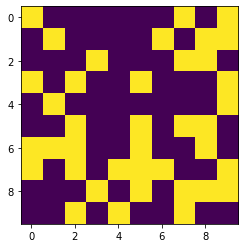

In [21]:
size = (10, 10)
J = np.prod(size)
hid_layer = 10
layers = [(2, hid_layer), (hid_layer, 2)]
params = gen_params(1, 2 * hid_layer + hid_layer * 2)
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid)
print(grid.sum())

# Listing 12
## Mean field Q-learning: The main training loop

In [22]:
epochs = 75
lr = 0.0001
num_iter = 3 # controls how many times we iterate to get rid of the initial randomness from the mean field actions
losses = [[] for i in range(J)] # makes a list of lists to store the losses for each agent
replay_size = 50
replay = deque(maxlen=replay_size) # the experience replay is a deque collection, which is basically a list with a maximum size
batch_size = 10
gamma = 0.9 # the discount factor

for i in range(epochs):
    act_means = torch.zeros((J, 2)) # stores the mean field actions for all the agents
    q_next = torch.zeros(J) # stores the Q values for the next state after taking an action
    for m in range(num_iter): # since mean fields are initialized randomly, we iterate a few times to dilute the initial randomness
        for j in range(J): # iterates through all agents in the grid
            action_mean = mean_action(grid_, j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(), params[0], layers=layers)
            action = softmax_policy(qvals.detach(), temp=0.5)
            grid__[get_coords(grid_, j)] = action
            q_next[j] = torch.max(qvals).detach()
        grid_.data = grid__.data
    grid.data = grid_.data
    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j], act_means[j]) for j in range(J)])
    exp = (actions, rewards, act_means, q_next) # collects an experience and adds to the experience replay buffer
    replay.append(exp)
    shuffle(replay)
    if len(replay) > batch_size: # once the experience replay buffer has more experiences than the batch size parameter, starts training
        ids = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()
            qvals = torch.stack([qfunc(jmeans[h].detach(), params[0], layers=layers) for h in range(batch_size)])
            target = qvals.clone().detach()
            target[ : , torch.argmax(jacts, dim=1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(), 2))
            losses[j].append(loss.item())
            loss.backward()
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True

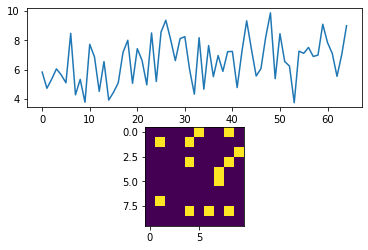

In [23]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.array(losses).mean(axis=0))
ax[1].imshow(grid)

# Listing 13
## Creating the MAgent environment

In [ ]:
import magent
import math
from scipy.spatial.distance import cityblock # imports the cityblock distance function from scipy to compute distances between agents on the grid

map_size = 30
env = magent.python.magent.GridWorld("battle", map_size=map_size) # sets up the environment in "battle" mode with a 30x30 grid
env.set_render_dir("MAgent/build/render") # sets up our ability to view the game after training

team1, team2 = env.get_handles()

# Listing 14
## Adding the agents

In [ ]:
hid_layer = 25
in_size = 359
act_space = 21
layers = [(in_size, hid_layer), (hid_layer, act_space)]
params = gen_params(2, in_size * hid_layer + hid_layer * act_space) # generates two parameter vectors to parameterize two DQNs
map_size = 30
width = height = map_size
n1 = n2 = 16 # sets the number of agents for each team to 16
gap = 1 # sets the initial gap distance between each team's agents
epochs = 100
replay_size = 70
batch_size = 25

side1 = int(match.sqrt(n1)) * 2
pos1 = []
for x in range(width // 2 - gap - size1, width // 2 - gap - side1 + side1, 2): # loops to position agents on team 1 on the left side of the grid
    for y in range((height - side1) // 2, (height - side1) // 2 + side1, 2):
        pos1.append([x, y, 0])

side2 = int(match.sqrt(n2)) * 2
pos2 = []
for x in range(width // 2 + gap, width // 2 + gap + side2, 2): # loops to position agents on team 2 on the right side of the grid
    for y in range((height - side1) // 2, (height - side1) // 2 + side1, 2):
        pos2.append([x, y, 0])
        
env.reset()
env.add_agents(team1, method="custom", pos=pos1) # adds the agents to the grid for team 1 using the position lists we just created
env.add_agents(team2, method="custom", pos=pos2)

In [ ]:
plt.imshow(env.get_global_minimap(30, 30)[ : , : , : ].sum(axis=2))

# Listing 15
## Finding the neighbors

In [6]:
def get_neighbors(j, pos_list, r=6): # given [x, y] positions of all agents in pos_list, returns indices of agents that are within the radius of agent j
    neighbors = []
    pos_j = pos_list[j]
    for i, pos in enumerate(pos_list):
        if i == j:
            continue
        dist = cityblock(pos, pos_j)
        if dist < r:
            neighbors.append(i)
    return neighbors

In [ ]:
get_neighbors(5, env.get_pos(team1))

# Listing 16
## Calculating the mean field action

In [7]:
def get_onehot(a, l=21): # converts integer representation of action into one-hot vector representation
    x = torch.zeros(l)
    x[a] = 1
    return x

def get_scalar(v): # converts one-hot vector action into integer representation
    return torch.argmax(x)

def get_mean_field(j, pos_list, act_list, r=7, l=21): # gets the mean field action of agent j; pos_list is what is returned by env.get_pos(team1), and l is the action space dimension
    neighbors = get_neighbors(j, pos_list, r=r) # finds all the neighbors of the agents using pos_list
    mean_field = torch.zeros(l)
    for k in neighbors:
        act_ = act_list[k]
        act = get_onehot(k_)
        mean_field += act
    tot = mean_field.sum()
    mean_field = mean_field / tot if tot > 0 else mean_field # makes sure we don't divide by zero
    return mean_field

# Listing 17
## Choosing actions

In [8]:
def infer_acts(obs, param, layers, pos_list, acts, act_space=21, num_iter=5, temp=0.5):
    N = acts.shape[0] # gets the number of agents
    mean_fields = torch.zeros(N, act_space)
    acts_ = acts.clone() # clones the action vector to avoid changing in place
    qvals = torch.zeros(N, act_space)
    
    for i in range(num_iter): # alternates a few times to converge on action
        for j in range(N): # loops through the agents and computes their neighborhood mean field action vectors
            mean_fields[j] = get_mean_field(j, pos_list, acts_)
            
        for j in range(N): # uses the mean field actions and state to compute Q values and select actions using a softmax policy
            state = torch.cat((obs[j].flatten(), mean_fields[j]))
            qs = qfunc(state.detach(), param, layers=layers)
            qvals[j, : ] = qs[ : ]
            acts_[j] = softmax_policy(qs.detach(), temp=temp)
    return acts_, mean_fields, qvals

def init_mean_field(N, act_space=21): # randomly initializes the mean field vectors
    mean_fields = torch.abs(torch.rand(N, act_space))
    for i in range(mean_fields.shape[0]):
        mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
    return mean_fields

# Listing 18
## The training function

In [9]:
def train(batch_size, replay, param, layers, J=64, gamma=0.5, lr=0.001):
    ids = np.random.randint(low=0, high=len(replay), size=batch_size) # generates a random list of indices to subset the experience replay
    exps = [replay[idx] for idx in ids] # subsets the experience replay buffer to get a mini-batch of data
    losses = []
    jobs = torch.stack([ex[0] for ex in exps]).detach() # collects all states from the mini-batch into a single tensor
    jacts = torch.stack([ex[1] for ex in exps]).detach() # collects all actions from the mini-batch into a single tensor
    jrewards = torch.stack([ex[2] for ex in exps]).detach() # collects all rewards from the mini-batch into a single tensor
    jmeans = torch.stack([ex[3] for ex in exps]).detach() # collects all mean field actions from the mini-batch into a single tensor
    vs = torch.stack([ex[4] for ex in exps]).detach() # collects all state values from the mini-batch into a single tensor
    qs = []
    
    for h in range(batch_size): # loops through each experience in the mini-batch
        state = torch.cat((jobs[h].flatten, jmeans[h]))
        qs.append(qfunc(state.detach(), param, layers=layers)) # computes Q values for each experience in the replay
    qvals = torch.stack(qs)
    target = qvals.clone().detach()
    target[ : , jacts] = jrewards + gamma * torch.max(vs, dim=1)[0] # computes the target Q values
    
    loss = torch.sum(torch.pow(qvals - target.detach(), 2))
    losses.append(loss.detach().item())
    loss.backward()
    with torch.no_grad(): # stochastic gradient descent
        param = param - lr * param.grad
    param.requires_grad = True
    return np.array(losses).mean()

# Listing 19
## Initializing the actions

In [ ]:
N1 = env.get_num(team1) # stores the number of agents on each team
N2 = env.get_num(team2)
step_ct = 0
acts_1 = torch.randint(low=0, high=act_space, size=(N1, )) # initializes the actions for all the agents
acts_2 = torch.randint(low=0, high=act_space, size=(N2, ))

replay1 = deque(maxlen=replay_size) # creates a replay buffer using a deque data structure
replay2 = deque(maxlen=replay_size)

qnext1 = torch.zeros(N1) # creates tensors to store the Q(s') values, where s' is the next state
qnext2 = torch.zeros(N2)

act_means1 = init_mean_field(N1, act_space) # initializes the mean fields for each agent
act_means2 = init_mean_field(N2, act_space)

rewards1 = torch.zeros(N1) # creates tensors to store the rewards for each agent
rewards2 = torch.zeros(N2)

losses1 = []
losses2 = []

# Listing 20
## Taking a team step and adding to the replay

In [11]:
def team_step(team, param, acts, layers):
    obs = env.get_observation(team) # gets observation tensor from team, which is a 16x13x13x7 tensor
    ids = env.get_agent_id(team) # gets the list of indices for the agents that are still alive
    obs_small = torch.from_numpy(obs[0][ : , : , : , [1, 4]]) # subsets the observation tensor to only get the positions of the agents
    agent_pos = env.get_pos(team) # gets the list of coordinates for each agent on a team
    acts, act_means, qvals = infer_acts(obs_small, param, layers, agent_pos, acts) # decides which actions to take using the DQN for each agent
    return acts, act_means, qvals, obs_small, ids

def add_to_replay(replay, obs_small, acts, rewards, act_means, qnext): # adds each individual agent's experience separetely to the replay buffer
    for j in range(rewards.shape[0]): # loops through each agent
        exp = (obs_small[j], acts[j], rewards[j], act_means[j], qnext[j])
        replay.append(exp)
    return replay

# Listing 21
## Training loop

In [ ]:
for i in range(epochs):
    done = False
    while not done: # while the game is not over
        acts_1, act_means1, qvals1, obs_small_1, ids_1 = team_step(team1, params[0], acts_1, layers) # uses the team_step method to collect environment data and choose actions for the agents using the DQN
        env.set_action(team1, acts_1.detach().numpy().astype(np.int32))
        acts_2, act_means2, qvals2, obs_small_2, ids_2 = team_step(team2, params[0], acts_2, layers)
        env.set_action(team2, acts_2.detach().numpy().astype(np.int32))
        
        done = env.step() # takes a step in the environment, which will generate a new observations and rewards
        
        _, _, qnext1, _, ids_1 = team_step(team1, params[0], acts_1, layers) # reruns team_step to get the Q values for the next state in the environment
        _, _, qnext2, _, ids_2 = team_step(team2, params[0], acts_2, layers)
        
        env.render() # renders the environment for viewing later
        
        rewards1 = torch.from_numpy(env.get_reward(team1)).float() # collects the rewards into a tensor for each agent
        rewards1 = torch.from_numpy(env.get_reward(team2)).float()
        
        replay1 = add_to_replay(replay1, obs_small_1, acts_1, rewards1, act_means1, qnext1) # adds to experience replay
        replay2 = add_to_replay(replay2, obs_small_2, acts_2, rewards2, act_means2, qnext2)
        shuffle(replay1) # shuffles the replay buffer
        shuffle(replay2)
        
        ids_1_ = list(zip(np.arange(ids_1.shape[0]), ids_1)) # builds a zipped list of IDs to keep track of which agents died and will be cleared from the grid
        ids_2_ = list(zip(np.arange(ids_2.shape[0]), ids_2))
        
        env.clear_dead() # clears the dead agents off the grid
        
        ids_1 = env.get_agent_id(team1) # now that the dead agents are cleared, gets the new list of agent IDs
        ids_2 = env.get_agent_id(team2)
        
        ids_1_ = [i for (i, j) in ids_1_ if j in ids_1] # subsets the old list of IDs based on which agents are still alive
        ids_2_ = [i for (i, j) in ids_2_ if j in ids_2]
        
        acts_1 = acts_1[ids_1_] # subsets the action list based on the agents that are still alive
        acts_2 = acts_1[ids_2_]
        
        step_ct += 1
        if step_ct > 250:
            break
            
        if len(replay1) > batch_size and len(replay2) > batch_size: # if the replay buffers are sufficiently full, starts training
            loss1 = train(batch_size, replay1, params[0], layers=layers, J=N1)
            loss2 = train(batch_size, replay1, params[1], layers=layers, J=N2)
            losses1.append(loss1)
            losses2.append(loss2)